In [3]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import copy
from scipy.signal import butter, filtfilt
from scipy.signal import czt
import csv
import pywt


In [4]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_2.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)


In [5]:
raw_data_channel_0 = raw_data[0]

tmp_real=sum(raw_data_channel_0.real)/len(raw_data_channel_0)
tmp_img= sum(raw_data_channel_0.imag)/len(raw_data_channel_0)
raw_data_channel_0=raw_data_channel_0-complex(tmp_real,tmp_img)


In [6]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

In [7]:
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP*2] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP*2)]
first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 1)]


In [8]:
# tmp_frame = [np.diff(frame) for frame in first_chirps_of_frame]
# first_chirps_of_frame = tmp_frame

In [9]:
fft_chirps = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]
magnitude_spectrums = [np.abs(fft_chirp) for fft_chirp in fft_chirps]

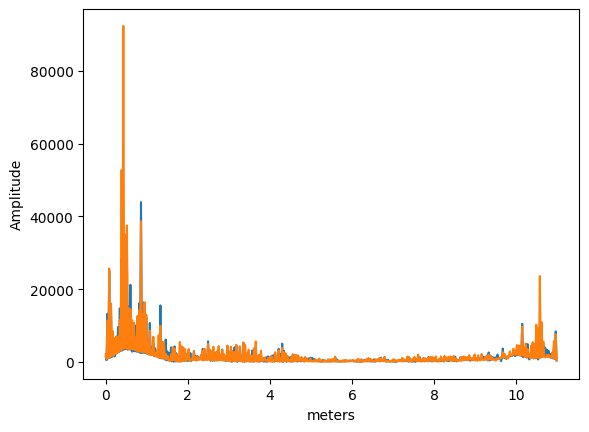

In [10]:
x= np.arange(0,11,11/len(magnitude_spectrums[0]))
plt.plot(x,magnitude_spectrums[0])
plt.plot(x,magnitude_spectrums[-1])
plt.xlabel('meters')
plt.ylabel('Amplitude')
plt.show()

In [11]:
#find it's manitude
magnitude_index = np.zeros(shape=len(magnitude_spectrums),dtype=int)
for  magnitude_spectrum in magnitude_spectrums:
    magnitude = np.abs(magnitude_spectrum)
    max_index=np.argmax(magnitude_spectrum[1:-1])
    # max_value = max(magnitude[1:-1])
    # max_index = np.where(max_value == magnitude)[0]
    magnitude_index[max_index]+=1
max_bin = max(magnitude_index)
bin_of_interest = np.where(max_bin ==magnitude_index )[0]

for i,val in enumerate(magnitude_index):
    if(0!=val):
        print("index:",i," : ",val)
print("bin of interest:",bin_of_interest)


index: 13  :  121
index: 15  :  54
index: 17  :  1180
index: 19  :  2438
index: 21  :  262
index: 23  :  562
index: 25  :  9
index: 29  :  1
index: 39  :  1358
index: 61  :  14
index: 79  :  1
bin of interest: [19]


300.0


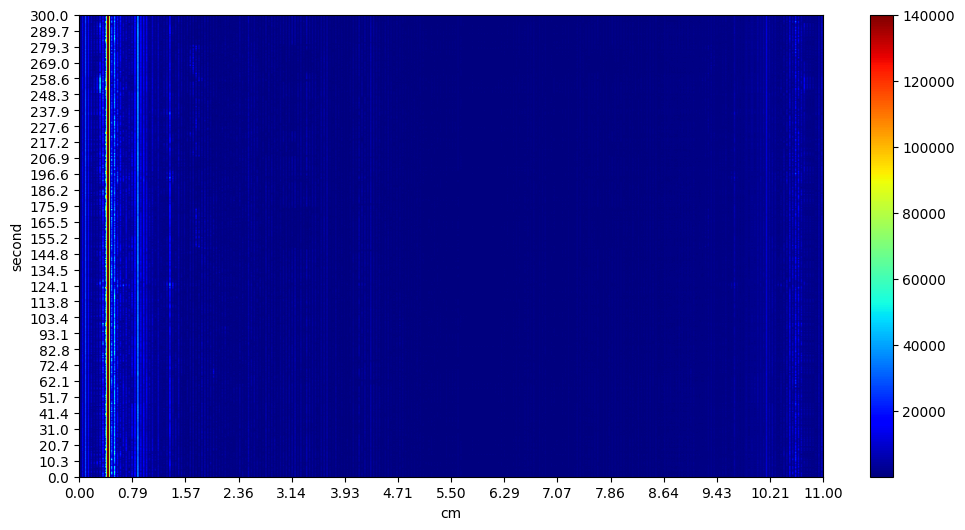

In [12]:
tmp_array= copy.deepcopy(magnitude_spectrums)
# tmp_array[:,bin_of_interest]=140000
for tmp in tmp_array:
    tmp[bin_of_interest]=140000
    tmp[bin_of_interest+1]=140000
plt.figure(figsize=(12, 6))
xmin=0
xmax=11
x = np.linspace(xmin, xmax, 15)
ymin=0
ymax=len(tmp_array)/20 #6000 chirp ~6000 frame each second has 20 frame -> second
#ymax ~300s ~5mins
print(ymax)
y = np.linspace(ymin, ymax, 30)
plt.xticks(x)
plt.yticks(y)

plt.imshow(tmp_array, cmap='jet', aspect='auto',extent=[xmin,xmax,ymin,ymax])
plt.xlabel('cm')
plt.ylabel('second')
plt.colorbar()
plt.show()


bin of interested fft: [19]


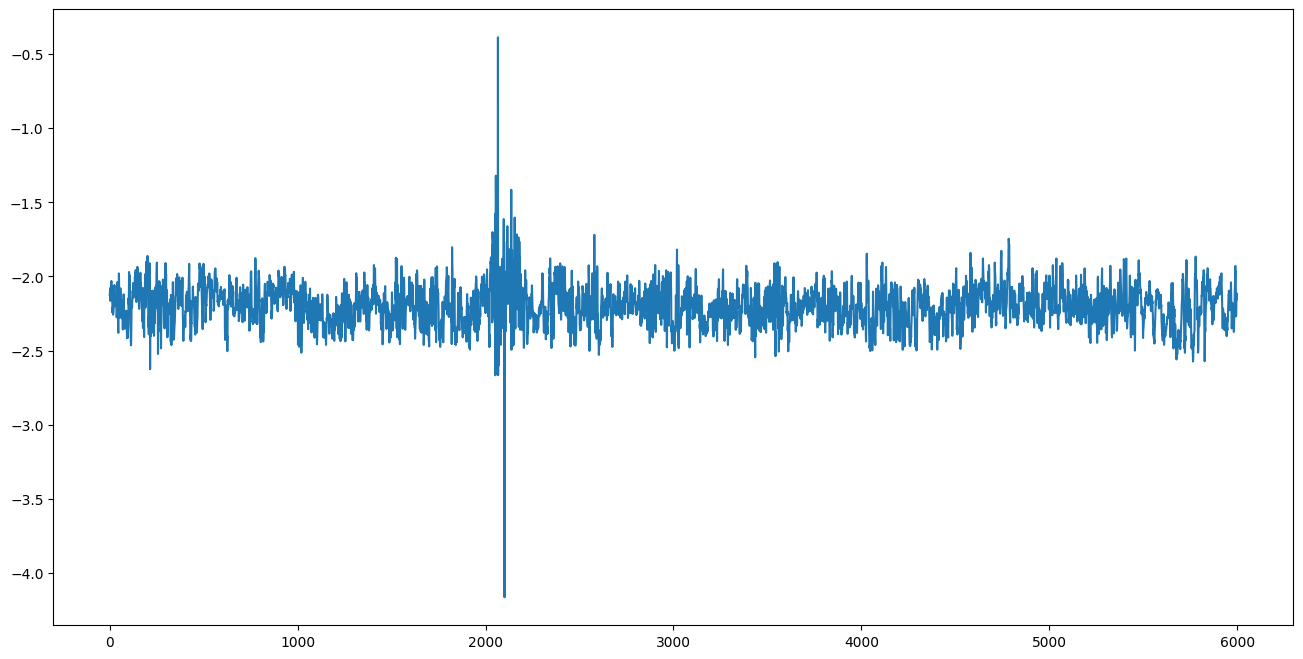

In [13]:
print("bin of interested fft:",bin_of_interest)
interested_ffts =[]
    
for _i,chirp_frame in enumerate(fft_chirps):
    interested_ffts.append(chirp_frame[bin_of_interest])

interested_angles = np.angle(np.array(interested_ffts).flatten())
unwrapped_angles=np.unwrap(interested_angles)
plt.figure(figsize=(16,8))
plt.plot(unwrapped_angles)
plt.show()

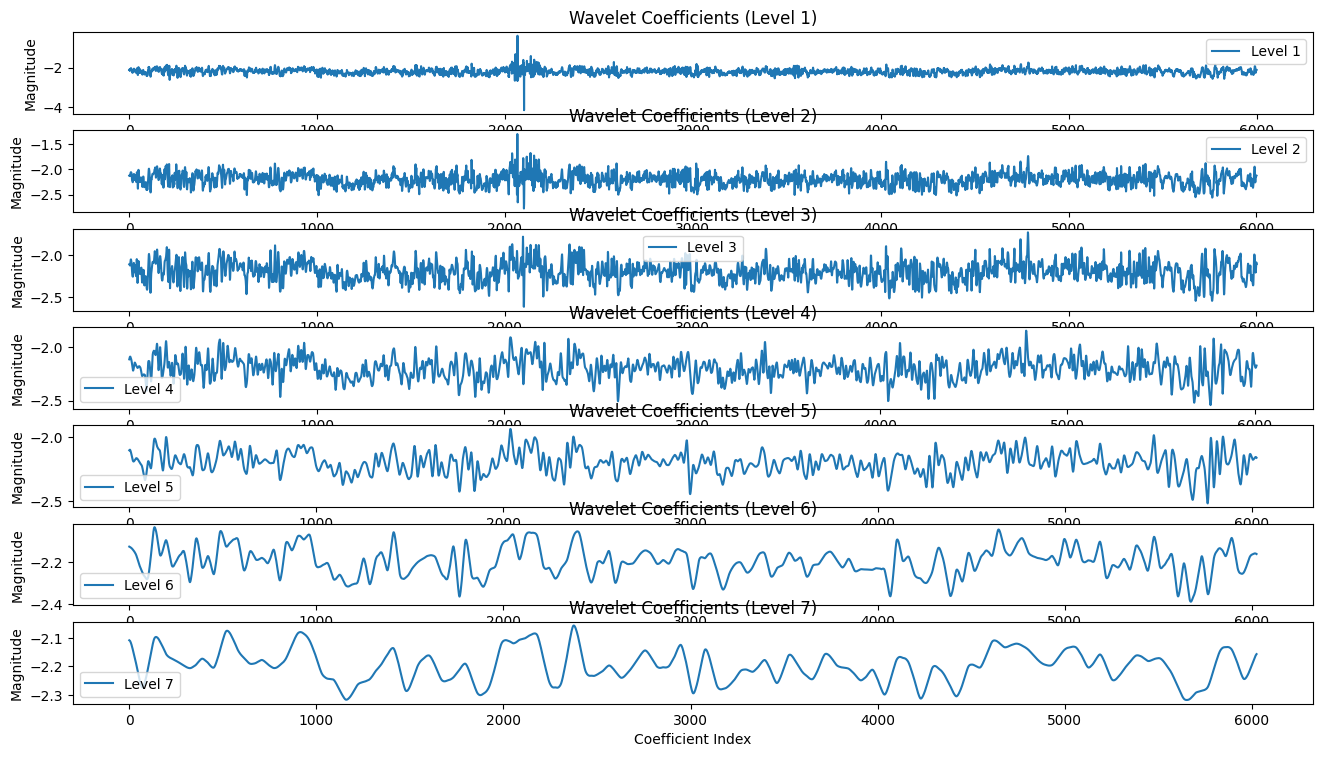

In [30]:

wavelet = 'sym6'  # Choose a wavelet function (e.g., Daubechies 4)
level = 6  # Number of decomposition levels
coeffs = pywt.wavedec(unwrapped_angles, wavelet, level=level)
reconstructed_coeffs = []
for i in range(level, -1, -1):
    current_coeffs = coeffs[:i+1] + [None] * (level - i)  # Pad the remaining levels with None
    reconstructed_signal = pywt.waverec(current_coeffs, wavelet)
    reconstructed_coeffs.append(reconstructed_signal)

plt.figure(figsize=(16, 10))
for i in range(0,len(reconstructed_coeffs)):
    plt.subplot(level + 2, 1, i + 2)
    plt.plot(reconstructed_coeffs[i], label=f'Level {i+1}')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Magnitude')
    plt.title(f'Wavelet Coefficients (Level {i+1})')
    plt.legend()


In [34]:

wavelet = 'sym6'  # Choose a wavelet function (e.g., Daubechies 4)
level = 6  # Number of decomposition levels
coeffs = pywt.wavedec(unwrapped_angles, wavelet, level=level)



# Get the frequency corresponding to the scale at level 6
frequency = pywt.scale2frequency(wavelet, coeffs[0].shape[0])
print(frequency)
plt.figure(figsize=(16, 10))
for i in range(0,len(coeffs)):
    plt.subplot(level + 2, 1, i + 2)
    plt.plot(coeffs[i], label=f'Level {len(coeffs)-i}')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Magnitude')
    plt.title(f'Wavelet Coefficients (Level {len(coeffs)-i})')
    plt.legend()


/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(


AttributeError: 'int' object has no attribute 'lower'

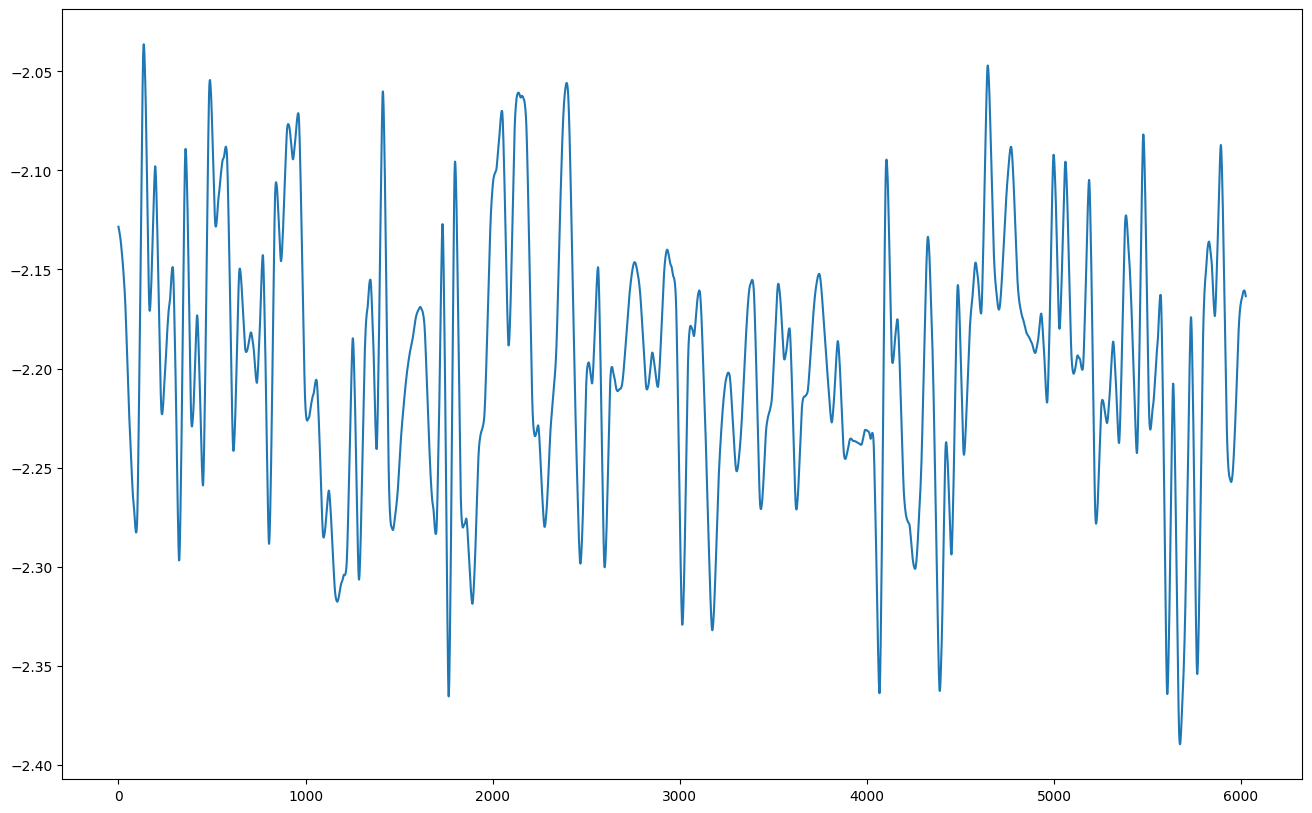

In [29]:
plt.figure(figsize=(16, 10))
plt.plot(reconstructed_coeffs[5])

plt.show()

In [26]:
from scipy.signal import stft
frequencies, time, stft_data = stft(unwrapped_angles, fs=20.0, nperseg=20, noverlap=0)

# plt.pcolormesh(time, frequencies, np.abs(stft_data))
print("--",reconstructed_coeffs[5].shape)
for data in reconstructed_coeffs[5]:
    print(data)
    # print(np.max(np.abs(data[])))
    # print(np.argmax(np.abs(data[1:-1])))

# peak_indices = np.argmax(np.abs(stft_data[1:-1]), axis=0)
# print(peak_indices)
# peak_frequencies = frequencies[peak_indices]

# plt.plot(time)
# plt.figure(figsize=(16, 10))
# plt.plot(time, peak_frequencies)
# plt.xlabel('Time')
# plt.ylabel('Frequency')
# plt.title('Complex Signal STFT Spectrogram')
# plt.show()

-- (6026,)
-2.112214355225917
-2.113183220825714
-2.114227798361713
-2.1153617403548512
-2.1165922655206946
-2.1179319196685102
-2.1193802713077727
-2.1209304266972966
-2.1225916860330307
-2.1243704883569063
-2.1262506810239468
-2.128212317543331
-2.130240897855232
-2.132312491044806
-2.1344249090461913
-2.1365844459383028
-2.1387699277733154
-2.140963954014076
-2.1431675007223885
-2.145379175921489
-2.1475970526803745
-2.1498260209546243
-2.1520447921555625
-2.154223300877484
-2.15635485187314
-2.1584259445640828
-2.160445834182021
-2.1624414369151266
-2.164413121535327
-2.166369772054949
-2.1683142818931143
-2.1702379883831644
-2.172157244949654
-2.174088880981896
-2.176008030025346
-2.177882868188581
-2.17969891639558
-2.1814267470201636
-2.1830743809925077
-2.184668068776481
-2.186188357957863
-2.187624181973721
-2.1889976945352316
-2.19032858756627
-2.1916389205404156
-2.192964595273657
-2.1943011148042832
-2.195632686069558
-2.1969841949273605
-2.1983722447560026
-2.1997998669738

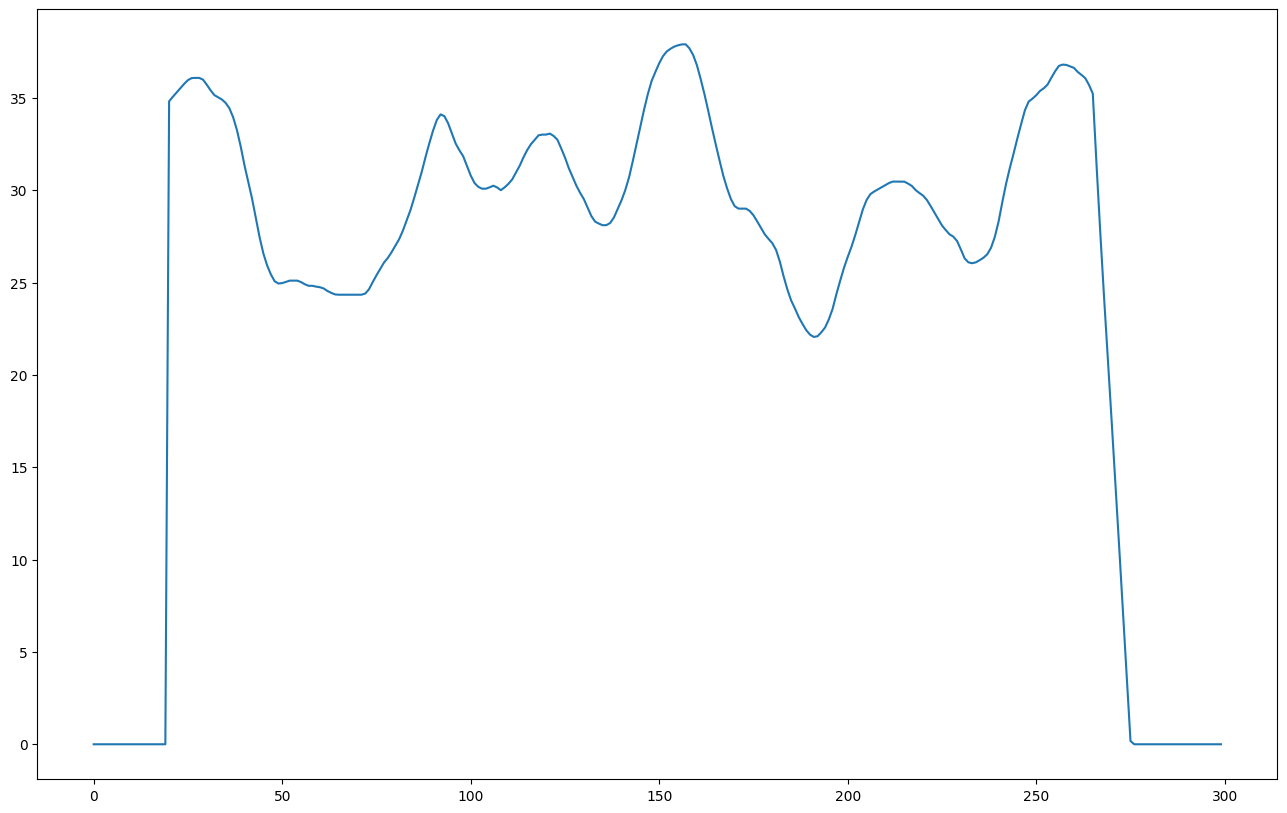

In [18]:
#plot breath
breaths=[]

with open('FMCW Radar/Heart Rate & Breathing Rate/Breath_1.csv', 'r') as file:
# Read the lines of the file
    lines = file.readlines()
    breaths = [float(breath) for breath in lines]
plt.figure(figsize=(16, 10))
plt.plot(breaths)
plt.show()

